In [ ]:
# AirCast - LSTM-Based AQI Prediction using PyTorch


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [7]:
# Load dataset
df = pd.read_csv('AQI_DATA.csv')  # Replace with your dataset path

# Extract relevant columns (e.g., Date, AQI)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
aqi_data = df[['AQI Value']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
aqi_data_scaled = scaler.fit_transform(aqi_data)

# Convert to a supervised learning problem
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30  # Using 30 days to predict the next day's AQI
X, y = create_sequences(aqi_data_scaled, seq_length)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X).float()
y_train = torch.from_numpy(y).float()

# Create DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [8]:
class LSTM_AQI(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM_AQI, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  # Only one feature: AQI
hidden_size = 64
num_layers = 2
model = LSTM_AQI(input_size, hidden_size, num_layers)


In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
model.train()

for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0018
Epoch [20/100], Loss: 0.0031
Epoch [30/100], Loss: 0.0018
Epoch [40/100], Loss: 0.0009
Epoch [50/100], Loss: 0.0010
Epoch [60/100], Loss: 0.0006
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0008


In [10]:
model.eval()
with torch.no_grad():
    # Predicting the last sequence
    last_seq = torch.from_numpy(aqi_data_scaled[-seq_length:]).float().unsqueeze(0)
    predicted_aqi = model(last_seq).cpu().numpy()
    predicted_aqi = scaler.inverse_transform(predicted_aqi)
    print(f'Predicted AQI: {predicted_aqi[0][0]:.2f}')


Predicted AQI: 19.10


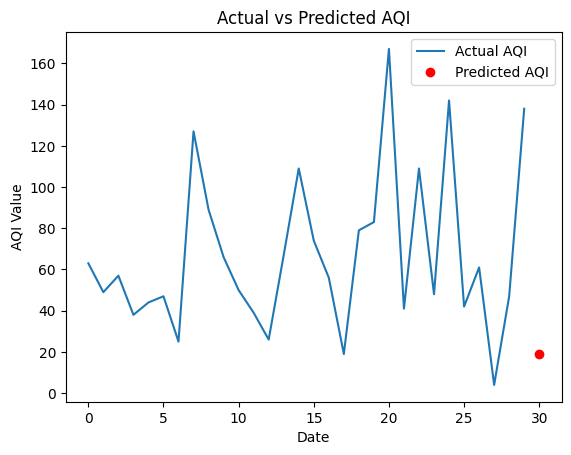

In [13]:
# Plot actual vs predicted AQI
actual_aqi = scaler.inverse_transform(aqi_data_scaled[-seq_length:])
plt.plot(range(len(actual_aqi)), actual_aqi, label='Actual AQI')
plt.plot(len(actual_aqi), predicted_aqi, 'ro', label='Predicted AQI')
plt.xlabel('Date')
plt.ylabel('AQI Value')
plt.title('Actual vs Predicted AQI')
plt.legend()
plt.show()


In [14]:
torch.save(model.state_dict(), 'lstm_aqi_model.pth')
